# Build your own interactive plotting function - Polariton dispersion simulation

In this tutorial, we are going to learn how to simulate a polariton dispersion, as can be measured experimentally by fourier optical transform [ref](https://doi.org/10.1103/PhysRevLett.73.2043).

Here, more precisely, we are going to simulate the dispersion of a perfectly regular polaritonic lattice, evenly illuminated. These hypotheses allow us to simplify massively the problem, making it solvable quite easily using this package. We are first going to show how to perform this compuitation, before building from the ground up an interactive plotting function to show the results.

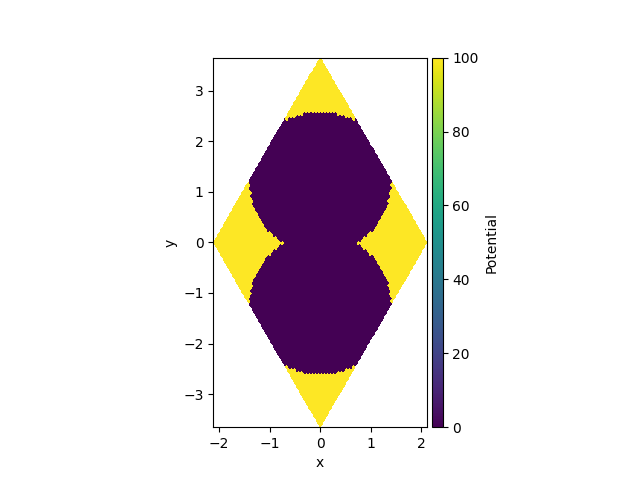

In [1]:
import numpy as np
import xarray as xr

from bloch_schrodinger.potential import honeycomb
from bloch_schrodinger.solver import Solver


# We first create a simple honeycomb lattice on which to perform the computation
honey = honeycomb(
    a = 2.4,
    rA = 1.4,
    rB = 1.4,
    res=(70,70) # low resolution to quicken the computations
)

%matplotlib widget
honey.plot()

In [2]:
solv = Solver(
    potentials=honey, # We have a single field
    alphas = 1.2
)

res = 50
kl = 2.5
solv.create_reciprocal_grid(
    kx = np.linspace(-kl, kl, res),
    ky = np.linspace(0, kl, res // 10) # We solve only on a few slices to avoid long computations
)

eigva, eigve = solv.solve(
    n_eigva = 6 # We'll solve for the s and p bands
)

100%|██████████| 250/250 [02:39<00:00,  1.56it/s]


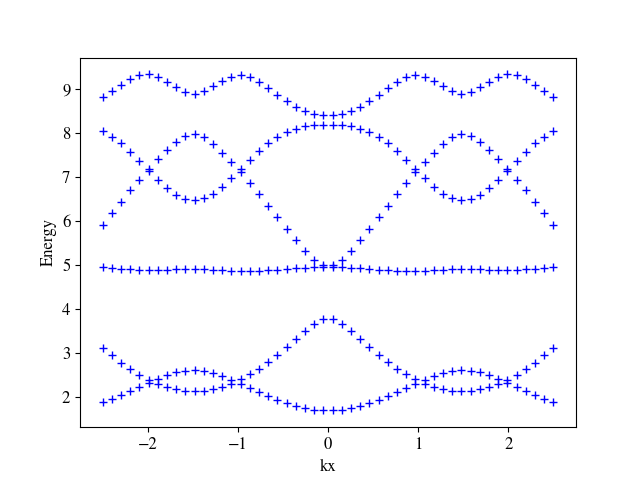

In [3]:
from bloch_schrodinger.plotting import plot_bands

plot_bands(
    eigva,
    dim = 'kx',
    linekws = {"color":"blue", "marker":"+", 'linestyle':'none'}
)

## Computing the form factor

The intensity as measured in the optical Fourier space of the photoluminescence signal is proportional to the form factor:

$$f^n(\textbf{k}) = \left| \iint_{UC} u^n_{\textbf{k}}(\textbf{r}) d \textbf{r}\right|^2$$

because we have a direct access to $u^n_{\textbf{k}}(\textbf{r})$, which is simply the eigenvector computed by our solver.

A single line of code is thus needed to compute $f^n(\textbf{k}) $:

In [4]:
fk = abs(eigve.sum(dim=['a1', 'a2']))**2
fk = fk / fk.max() # A bit of normalization 

We can plot this form factor as the color of the band structure, let's do this quickly using plotly. If you don't want to install the package (`pip install plotly`), you can skip the next cell.

In [5]:
import plotly.graph_objects as go

fig = go.Figure()
for b in eigva.band:
    fig.add_trace(go.Scatter(
        x=eigva.kx, y=eigva.sel(ky = 0, band = b), mode='markers', 
        marker=dict(
            color = fk.sel(ky = 0, band = b),
            cmin = 0,
            cmax = 1,
            colorbar=dict(
                    title=dict(text="form factor")
                )
            ),
    ))
    
fig.update_layout(
    showlegend = False,
    title=dict(
        text='Form factor for each band'
    ),
    xaxis=dict(
        title=dict(
            text='kx'
        )
    ),
    yaxis=dict(
        title=dict(
            text='Energy'
        )
    ),
    width = 800
)

fig.show()

Now, we can immedialtly see that some bands will be brighter than others. We can hovever go further. Let's simulate an actual dispersion with finite linewidths and spatial broadening. 

In [6]:
# Our dispersion is goind to be represented by a DataArray with coordinates, kx, ky and E, plus all the parameters coordinates if any

# Let's build the coordinates first
e_res = 100

pad_e = (eigva.max().data - eigva.min().data)*0.05
E = np.linspace(eigva.min().data-pad_e, eigva.max().data+pad_e, e_res)

E = xr.DataArray(E, coords={"E":E})

# This dictionary stores all the coordinates of our future dispersion array, making sure to keep eventual parameter coordinates (here there is none)
Coords = {**{dim:eigva.coords[dim] for dim in eigva.dims if dim not in ['band']}, 'E':E}

# We instanciate an empty DataArray
Dispersion = xr.DataArray(
    data = np.zeros(tuple((len(coord.data) for coord in Coords.values()))),
    coords = Coords
)

# We are going to fill the dispersions with the form factor, using xarray indexing

indexer = abs(Dispersion.E - eigva).argmin(dim='E')
Dispersion[:,:,indexer] = fk


Let's plot the Dispersion just to see how it looks

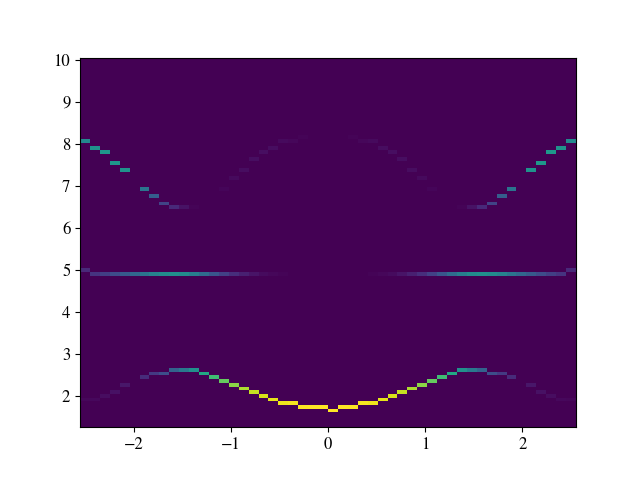

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.pcolormesh(Dispersion.kx, Dispersion.E, Dispersion.transpose('E', 'kx', 'ky').sel(ky = 0))
plt.show()

Perfect, now we just have to apply some gaussian filtering. Actually, we would need lorentzian blurring along E and gaussian blurring along kx and ky. This could be done easily using some fft convolutions, but let's keep it short and simple. Gaussian filters are good enough.

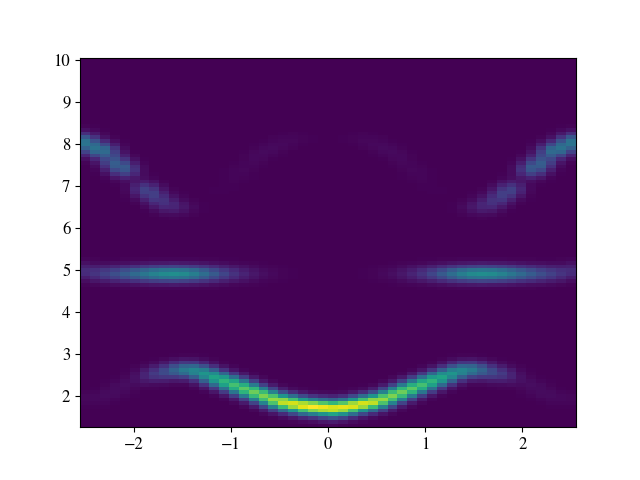

In [8]:
from xarray import apply_ufunc
from scipy.ndimage import gaussian_filter

# We are going to apply a custom blurring function that respects the existence of parameter dimensions, using the dedicated xarray function 'apply_ufunc'

our_filter = lambda arr: gaussian_filter(arr, sigma=(1.5,1,0.2)) # sigma represents the blur strength along each dimension in pixels. Since ky is 5 times less resolved than kx, we need to adjust the blur

blurred_dispersion = apply_ufunc(
    our_filter, 
    Dispersion,
    input_core_dims=[['E', 'kx', 'ky']], # Telling apply_ufunc not to broadcast on these dimensions
    output_core_dims=[['E', 'kx', 'ky']]
)

fig, ax = plt.subplots()
ax.pcolormesh(blurred_dispersion.kx, blurred_dispersion.E, blurred_dispersion.transpose('E', 'kx', 'ky').sel(ky = 0))
plt.show()

Now we got a nice, experimentally-looking dispersion. We finally just need to create an interactive function to explore an eventual parameter space. We will build it with the same concepts used in the plotting submodule.

# Interactive Plotting

We are going to build a simple function that will allow us to plot the dispersion as a pcolormesh. We want to be able to chose the two axes to plot against, an the others dimensions should be accessible through sliders. A nice addition would also be to overlap the actual band structure eigva.

The general structure will look like that:

In [9]:
def plot_dispersion(eigva:xr.DataArray, dispersion:xr.DataArray, dims:list[str] = ['kx', 'E']):
    """An interactive dispersion plotter.

    Args:
        eigva (xr.DataArray): The eigenvalues, they will be plotted as contour lines.
        dispersion (xr.DataArray): The dispersion array, must contain the dimensions indicated in 'dims'
        dims (list[str], optional): The two dimensions to plot against. Defaults to ['kx', 'E'].
    """

    # --- Create the sliders and chose the initial values for each additional dimension ---
    
    # --- Construct the initial figure using matplotlib, it will be composed of a pcolormesh and some lines plot, or a contour plots if dims = ['kx','ky'] ---
    
    # --- Create a updater function that changes the data plotted according to the sliders input ---
    
    # --- display the figure ---
    
    pass

We are going to build each part in a separate function, before combining them all

In [10]:
# first, we need to define the sliders, we are going to build a simpler version of the 'create_sliders' from the utils submodule

from ipywidgets import FloatSlider, IntSlider # Our parameter space is made of float and integer dimensions

def make_sliders(arr:xr.DataArray, excluded_dims:list[str])->dict:
    """A helper function that creates a dictionary of sliders object

    Args:
        arr (xr.DataArray): The DataArray whose coordinates will be use to create the sliders.
        excluded_dims (list[str]): Dimensions excluded from the dictionary.
    
    Returns:
        list_dims (list['str']): The list of dimensions, returned in the main function as we will need it again 
        sliders (dict): The dictionary containing (dim,slider) pairs
    """
    
    list_dims = [dim for dim in arr.dims if dim not in excluded_dims] # gather all valid dimensions
    sliders = {}
    
    for dim in list_dims:
        coord = arr.coords[dim] # recover the coordinate array corresponding to dimension 'dim' 
        val = coord.min() # The slider will start to the left
        if np.issubdtype(coord.dtype, np.floating): # check if the dtype of coord is float or int
            sliders[dim] = FloatSlider( # Initiating a float slider
                min=float(coord.min()), # Minimum value for the slider
                max=float(coord.max()), # Maximum value for the slider
                step = float((coord.max() - coord.min()) / max(100, len(coord))), # Step resolution
                value=float(val), # Initial value
                description=dim # Name of the slider that will appear in the figure
            )
        else:
            sliders[dim] = IntSlider( # same principle but for an integer dimension
                min=coord.min(), 
                max=coord.max(), 
                step=1,
                value=val, 
                description=dim
            )

    return list_dims, sliders

A slider object allow a function to access its value in an interactive session. This value can be easily accessed using its value attribute (`slider.value`).

Now, we need to create the actual figure object. We are going to create three subfunctions, one for the pcolormesh, one for plotting eigva lines if the dims are (k,E), and one for plotting a contour plot if the dims are (k,k)

In [18]:
def make_mesh(
        coordx:xr.DataArray,
        coordy:xr.DataArray,
        disp_slice:xr.DataArray,
        setaspect:bool = False
    ):
    """A helper function to create a dispersion pcolormesh

    Args:
        coordx (xr.DataArray): The coordinate on the x-axis
        coordy (xr.DataArray): The coordinate on the y-axis
        disp_slice (xr.DataArray): A 2D xr.DataArray containing the initial dispersion slice to plot
        setaspect (bool, optional): Wheter no equalize the axes aspect ratio. Defaults to False.

    Returns:
        tuple[Figure, Axes, QuadMesh]: The matplotlib objects created, that will be passed on to other functions
    """
    fig, ax = plt.subplots() # creating a Figure and Axes object
    
    mesh = ax.pcolormesh(coordx, coordy, disp_slice.transpose(coordy.name, coordx.name), # The transpose function ensures the slice is properly indexed for matplotlib
                         cmap='magma', shading = 'gouraud') 
    ax.set_xlabel(coordx.name) # labeling the axes is always nice
    ax.set_ylabel(coordy.name)
    if setaspect:
        ax.set_aspect('equal') # We want identical scales for x and y if we plot ['kx','ky']
    cbar = fig.colorbar(mesh) # adding a colorbar, mostly for show since the data is normalized
    return fig, ax, mesh

    
def add_dispersions(
        ax,
        coordx:xr.DataArray,
        eigva_slice:xr.DataArray
    ):
    """A helper function to add the initial lines to our plot

    Args:
        ax (Axes): the Axes object on which to plot the lines
        coordx (xr.DataArray): The x-axis coordinate
        eigva_slice (xr.DataArray): A single 2D slice of the band structure

    Returns:
        list[Line2D]: A list of Line2D objects
    """
    lines = [] # We need to gather all line2D objects we are going to create
    for b in eigva_slice.band: # Iterate over all bands
        line = ax.plot(coordx, eigva_slice.sel(band=b), linestyle = 'dashed', color = 'white', linewidth = 1) # We collect only a single band
        lines += line
    
    return lines

def add_contours(
        ax,
        coordx:xr.DataArray,
        coordy:xr.DataArray,
        eigva:xr.DataArray,
        energy:float
    ):
    """A helper function to create a contour of the dispersion when plotting in the (k,k) mode

    Args:
        ax (Axes): The Axes on which to plot
        coordx (xr.DataArray): The coordinate on the x-axis
        coordy (xr.DataArray): The coordinate on the y-axis
        eigva (xr.DataArray): The full eigenvalue DataArray is needed to plot the contours
        energy (float): the enrgy level at which to plot the contours

    Returns:
        list[QuadContourSet]: The list of QuadContourSet objects
    """
    contours = []
    for b in eigva.band: # We are going to find the bands crossing our the energy level and create a contour plot for each
        if eigva.sel(band = b).max() > energy > eigva.sel(band = b).min():
            contour = ax.contour(
                coordx, coordy, eigva.sel(band = b).transpose(coordy.name, coordx.name), 
                levels = np.array([energy]), # Only plot a single energy level, at the value 'energy'
                colors = 'white', linestyles = 'dashed', linewidths = 1# Some styling
            )
            contours += [contour]
    
    return contours

We can already test our plotting functions without interactivity

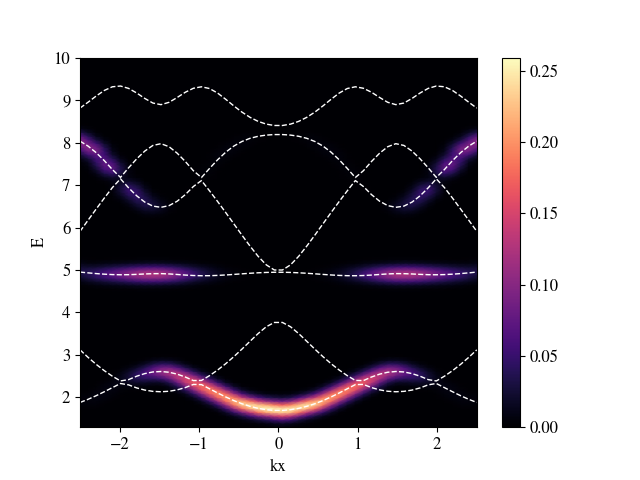

In [19]:
dims = ['kx', 'E'] # if you try with ['kx', 'ky'], change the initial energy selection, otherwise you'll see the edge of the dispersion

list_dim, sliders = make_sliders(blurred_dispersion, dims)

iskxky = dims == ['kx', 'ky'] or dims == ['ky', 'kx'] # Check the plotting mode

initial_sel = {dim:sliders[dim].value for dim in list_dim} # selecting initial plotting values for each of the slider dimensions
initial_eigva_sel = {dim:sliders[dim].value for dim in list_dim if dim in eigva.dims} # same for the eigenvalues, who don't share the same dimension as blurred_dispersion

# initial_sel['E'] = 3 # decomment if you plot ['kx', 'ky']

fig, ax, mesh = make_mesh(
    blurred_dispersion.coords[dims[0]],
    blurred_dispersion.coords[dims[1]],
    blurred_dispersion.sel(initial_sel, method = 'nearest')

)

if iskxky:
    contours = add_contours(
        ax,
        blurred_dispersion.coords[dims[0]],
        blurred_dispersion.coords[dims[1]],
        eigva.sel(initial_eigva_sel, method = 'nearest'),
        initial_sel['E']
    )
else:
    lines = add_dispersions(
        ax,
        blurred_dispersion.coords[dims[0]],
        eigva.sel(initial_eigva_sel, method = 'nearest')
    )
plt.show() # It is very ungly in ['kx', 'ky'] because the resolution there is very low, if you want to see more, increase the reciprocal grid resolution and wait for the solver to run

Now we are going to create the full function, adding the interactive part. The idea is simple: we need to update the plotted data when the sliders move.

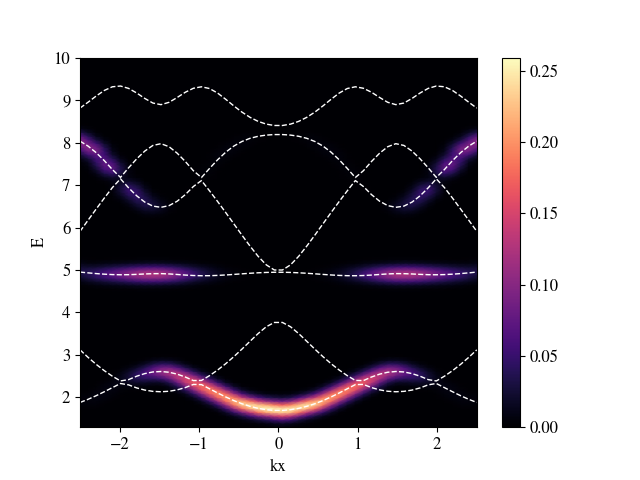

In [20]:
from ipywidgets import interactive_output, VBox
from IPython.display import display

def plot_dispersion(eigva:xr.DataArray, dispersion:xr.DataArray, dims:list[str] = ['kx', 'E']):
    """An interactive dispersion plotter.

    Args:
        eigva (xr.DataArray): The eigenvalues, they will be plotted as contour lines.
        dispersion (xr.DataArray): The dispersion array, must contain the dimensions indicated in 'dims'
        dims (list[str], optional): The two dimensions to plot against. Defaults to ['kx', 'E'].
    """

    # --- Create the sliders and chose the initial values for each additional dimension ---
    list_dim, sliders = make_sliders(dispersion, dims)

    iskxky = dims == ['kx', 'ky'] or dims == ['ky', 'kx'] # Check the plotting mode

    initial_sel = {dim:sliders[dim].value for dim in list_dim} # selecting initial plotting values for each of the slider dimensions
    initial_eigva_sel = {dim:sliders[dim].value for dim in list_dim if dim in eigva.dims} # same for the eigenvalues, who don't share the same dimension as blurred_dispersion

    # --- Construct the initial figure using matplotlib, it will be composed of a pcolormesh and some lines plot, or a contour plots if dims = ['kx','ky'] ---
    fig, ax, mesh = make_mesh(
        dispersion.coords[dims[0]],
        dispersion.coords[dims[1]],
        dispersion.sel(initial_sel, method = 'nearest')

    )
    
    if iskxky:
        contours = add_contours(
            ax,
            dispersion.coords[dims[0]],
            dispersion.coords[dims[1]],
            eigva.sel(initial_eigva_sel, method = 'nearest'),
            initial_sel['E']
        )
    else:
        lines = add_dispersions(
            ax,
            dispersion.coords[dims[0]],
            eigva.sel(initial_eigva_sel, method = 'nearest')
        )
        
    
    # --- Create a updater function that changes the data plotted according to the sliders input ---
    
    def update(**kwargs): # The update functions takes only sliders arguments, inside the function
        # --- selecting the new plotting parameters ---
        eigve_sel = {dim:kwargs[dim] for dim in list_dim} # No need for '.value' in the update function
        eigva_sel = {dim:kwargs[dim] for dim in list_dim if dim in eigva.dims}
         
        toplot = dispersion.sel(eigve_sel, method = 'nearest').transpose(dims[1], dims[0])
        
        mesh.set_array(toplot.data.flatten()) # We change the data in the pcolormesh, using the set_array method. This method need a flattened array
        mesh.autoscale()
        if iskxky:
            # The QuadContourSet object does not include an update method, so we have to redraw it each time
            nonlocal contours # Tell python contours is defined first outside the function
            
            for contour in contours:
                contour.remove()
                    
            contours = add_contours(
                ax,
                dispersion.coords[dims[0]],
                dispersion.coords[dims[1]],
                eigva.sel(eigva_sel, method = 'nearest'),
                kwargs['E']
            )
        else:
            for i, b in enumerate(eigva.band):
                lines[i].set_ydata(eigva.sel(**eigva_sel, band = b, method = 'nearest')) # Each band dispersion is updated separatly
        
        fig.canvas.draw_idle() # redraw the full plot once the sliders are updated
        
    # --- display the figure ---
    out = interactive_output(update, sliders) # Creates the interactive figure
    # Display everything
    display(VBox(list(sliders.values()) + [out]))
                
    
# Let's try it
plot_dispersion(
    eigva,
    blurred_dispersion,
    dims=['kx', 'E']
)

there you go! A fully operational interactive plotting function.